### Implementing GPT Model from Scratch

The smallest GPT-2 model (117 million parameters) has 12 attention heads and a context vector embedding size of 768. The largest GPT-2 model (1.5 billion parameters) has 25 attention heads and a context vector embedding size of 1600. Note that the embedding sizes of the token inputs and context embeddings are the same in GPT models (d_in = d_out).

In [40]:
LLM_SETTINGS_124M = {
    "token_count": 50257,   # Vocabulary size
    "seq_length": 1024,     # Context length
    "embed_size": 768,      # Embedding dimension
    "attn_heads": 12,       # Number of attention heads
    "num_layers": 12,       # Number of layers
    "dropout_prob": 0.1,    # Dropout rate
    "use_qkv_bias": False   # Query-Key-Value bias
}

### DUMMY GPT MODEL CLASS

In [41]:
import torch
import torch.nn as nn


class MockGPTModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embed = nn.Embedding(config["token_count"], config["embed_size"])
        self.position_embed = nn.Embedding(config["seq_length"], config["embed_size"])
        self.embed_dropout = nn.Dropout(config["dropout_prob"])
        
        # Placeholder for Transformer Block
        self.transformer_layers = nn.Sequential(
            *[MockTransformerLayer(config) for _ in range(config["num_layers"])]
        )
        
        # Placeholder for LayerNorm
        self.norm_layer = MockLayerNorm(config["embed_size"])
        self.output_layer = nn.Linear(
            config["embed_size"], config["token_count"], bias=False
        )

    def forward(self, input_idx):
        batch_size, seq_len = input_idx.shape
        token_embeddings = self.token_embed(input_idx)
        position_embeddings = self.position_embed(torch.arange(seq_len, device=input_idx.device))
        x = token_embeddings + position_embeddings
        x = self.embed_dropout(x)
        x = self.transformer_layers(x)
        x = self.norm_layer(x)
        logits = self.output_layer(x)
        return logits


class MockTransformerLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        # Placeholder implementation

    def forward(self, x):
        # This block does nothing and just returns its input.
        return x


class MockLayerNorm(nn.Module):
    def __init__(self, norm_shape, epsilon=1e-5):
        super().__init__()
        # Placeholder for LayerNorm interface

    def forward(self, x):
        # This layer does nothing and just returns its input.
        return x


Let's prepare the input data and initialize the new GPT model

### Step 1: Tokenization

In [43]:
import tiktoken
import torch

# Initialize tokenizer
text_encoder = tiktoken.get_encoding("gpt2")

# Create a list for storing tokenized sequences
token_batches = []

sentence_1 = "Every effort moves you"
sentence_2 = "Every day holds a"

# Tokenizing and appending to the batch
token_batches.append(torch.tensor(text_encoder.encode(sentence_1)))
token_batches.append(torch.tensor(text_encoder.encode(sentence_2)))

# Stack tensors along dimension 0
token_batches = torch.stack(token_batches, dim=0)

# Print the tokenized batch
print(token_batches)


tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


### Create an Instance of Dummy GPT Model

In [44]:
torch.manual_seed(123)
mock_model = MockGPTModel(LLM_SETTINGS_124M)
output_logits = mock_model(token_batches)

print("Output shape:", output_logits.shape)
print(output_logits)

Output shape: torch.Size([2, 4, 50257])
tensor([[[-0.9289,  0.2748, -0.7557,  ..., -1.6070,  0.2702, -0.5888],
         [-0.4476,  0.1726,  0.5354,  ..., -0.3932,  1.5285,  0.8557],
         [ 0.5680,  1.6053, -0.2155,  ...,  1.1624,  0.1380,  0.7425],
         [ 0.0447,  2.4787, -0.8843,  ...,  1.3219, -0.0864, -0.5856]],

        [[-1.5474, -0.0542, -1.0571,  ..., -1.8061, -0.4494, -0.6747],
         [-0.8422,  0.8243, -0.1098,  ..., -0.1434,  0.2079,  1.2046],
         [ 0.1355,  1.1858, -0.1453,  ...,  0.0869, -0.1590,  0.1552],
         [ 0.1666, -0.8138,  0.2307,  ...,  2.5035, -0.3055, -0.3083]]],
       grad_fn=<UnsafeViewBackward0>)


### GPT ARCHITECTURE PART 2: LAYER NORMALIZATION

In [45]:
torch.manual_seed(123)

# Create a random input tensor
sample_input = torch.randn(2, 5)  # A

# Define a simple neural network layer
neural_layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())

# Pass the input through the layer
output_result = neural_layer(sample_input)

# Print the output
print(output_result)

tensor([[0.2260, 0.3470, 0.0000, 0.2216, 0.0000, 0.0000],
        [0.2133, 0.2394, 0.0000, 0.5198, 0.3297, 0.0000]],
       grad_fn=<ReluBackward0>)


Before implementing the layer normalization, we shall apply the mean variance of the output vectors

In [46]:
# Compute mean along the last dimension
output_mean = output_result.mean(dim=-1, keepdim=True)

# Compute variance along the last dimension
output_variance = output_result.var(dim=-1, keepdim=True)

# Print mean and variance
print("Mean:\n", output_mean)
print("Variance:\n", output_variance)

Mean:
 tensor([[0.1324],
        [0.2170]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[0.0231],
        [0.0398]], grad_fn=<VarBackward0>)


Next, let us apply layer normalization to the layer outputs we obtained earlier. The operation consists of subtracting the mean and dividing by the square root of the variance (also known as standard deviation):

In [47]:
# Normalize the output
normalized_output = (output_result - output_mean) / torch.sqrt(output_variance)

# Compute mean and variance of the normalized output
normalized_mean = normalized_output.mean(dim=-1, keepdim=True)
normalized_variance = normalized_output.var(dim=-1, keepdim=True)

# Print results
print("Normalized layer outputs:\n", normalized_output)
print("Mean:\n", normalized_mean)
print("Variance:\n", normalized_variance)

Normalized layer outputs:
 tensor([[ 0.6159,  1.4126, -0.8719,  0.5872, -0.8719, -0.8719],
        [-0.0189,  0.1121, -1.0876,  1.5173,  0.5647, -1.0876]],
       grad_fn=<DivBackward0>)
Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


To improve readability, we can also turn off the scientific notation when printing tensor values by setting sci_mode to False:

In [48]:
# Set print options to disable scientific notation
torch.set_printoptions(sci_mode=False)

# Print mean and variance
print("Mean:\n", normalized_mean)
print("Variance:\n", normalized_variance)

Mean:
 tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


Let's now encapsulate this process in a PyTorch module that we can use in the GPT model later:

In [49]:
import torch
import torch.nn as nn

class NormLayer(nn.Module):
    def __init__(self, embed_size):
        super().__init__()
        self.epsilon = 1e-5
        self.gain = nn.Parameter(torch.ones(embed_size))
        self.bias = nn.Parameter(torch.zeros(embed_size))

    def forward(self, x):
        mean_val = x.mean(dim=-1, keepdim=True)
        variance_val = x.var(dim=-1, keepdim=True, unbiased=False)
        normalized_x = (x - mean_val) / torch.sqrt(variance_val + self.epsilon)
        return self.gain * normalized_x + self.bias

This specific implementation of layer Normalization operates on the last dimension of the input tensor x, which represents the embedding dimension (emb_dim).

The variable epsilon added to the variance to prevent division by zero during normalization.

The scale and shift are two trainable parameters (of the same dimension as the input) that the LLM automatically adjusts during training if it is determined that doing so would improve the model's performance on its training task.

This allows the model to learn appropriate scaling and shifting that best suit the data it is processing.

In [50]:
# Initialize the normalization layer
norm_layer = NormLayer(embed_size=5)

# Apply layer normalization
normalized_output = norm_layer(sample_input)

# Compute mean and variance of the normalized output
normalized_mean = normalized_output.mean(dim=-1, keepdim=True)
normalized_variance = normalized_output.var(dim=-1, unbiased=False, keepdim=True)

# Print results
print("Mean:\n", normalized_mean)
print("Variance:\n", normalized_variance)

Mean:
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance:
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


### GPT ARCHITECTURE PART 3: FEEDFORWARD NEURAL NETWORK WITH GELU ACTIVATION

In [52]:
import torch
import torch.nn as nn

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input_tensor):
        return 0.5 * input_tensor * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * 
            (input_tensor + 0.044715 * torch.pow(input_tensor, 3))
        ))


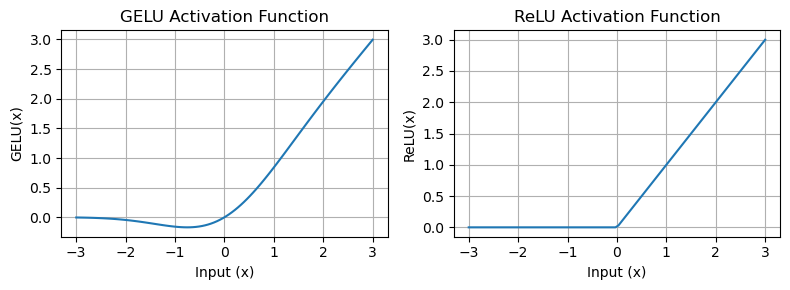

In [53]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

# Initialize activation functions
gelu_activation, relu_activation = GELU(), nn.ReLU()

# Generate sample data
input_values = torch.linspace(-3, 3, 100)
output_gelu, output_relu = gelu_activation(input_values), relu_activation(input_values)

# Plot the activation functions
plt.figure(figsize=(8, 3))
for i, (output, act_name) in enumerate(zip([output_gelu, output_relu], ["GELU", "ReLU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(input_values, output)
    plt.title(f"{act_name} Activation Function")
    plt.xlabel("Input (x)")
    plt.ylabel(f"{act_name}(x)")
    plt.grid(True)

plt.tight_layout()
plt.show()


We can see in the resulting plot, ReLU is a piecewise linear function that outputs the input directly if it is positive; otherwise, it outputs zero.

GELU is a smooth, nonlinear function that approximates ReLU but with a non-zero gradient for negative values

Next, let's use the GELU function to implement the small neural network module, FeedForward, that we will be using in the LLM's transformer block later:

In [54]:
import torch
import torch.nn as nn

class MLPBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(config["embed_size"], 4 * config["embed_size"]),
            GELU(),
            nn.Linear(4 * config["embed_size"], config["embed_size"]),
        )

    def forward(self, input_tensor):
        return self.network(input_tensor)


In [55]:
print(LLM_SETTINGS_124M["embed_size"])

768


In [56]:
# Initialize the feedforward network with the configuration
mlp_block = MLPBlock(LLM_SETTINGS_124M)

# Create a random input tensor
input_tensor = torch.rand(2, 3, 768)  # A

# Pass the input through the feedforward network
output_tensor = mlp_block(input_tensor)

# Print the output shape
print(output_tensor.shape)

torch.Size([2, 3, 768])


### GPT ARCHITECTURE PART 4: SHORTCUT CONNECTIONS

In [57]:
import torch
import torch.nn as nn

class DeepMLP(nn.Module):
    def __init__(self, layer_dims, enable_skip_connection):
        super().__init__()
        self.enable_skip = enable_skip_connection
        self.layers = nn.ModuleList([
            nn.Sequential(nn.Linear(layer_dims[0], layer_dims[1]), GELU()),
            nn.Sequential(nn.Linear(layer_dims[1], layer_dims[2]), GELU()),
            nn.Sequential(nn.Linear(layer_dims[2], layer_dims[3]), GELU()),
            nn.Sequential(nn.Linear(layer_dims[3], layer_dims[4]), GELU()),
            nn.Sequential(nn.Linear(layer_dims[4], layer_dims[5]), GELU())
        ])

    def forward(self, input_tensor):
        for layer in self.layers:
            # Compute the output of the current layer
            layer_output = layer(input_tensor)
            # Apply skip connection if enabled and shapes match
            if self.enable_skip and input_tensor.shape == layer_output.shape:
                input_tensor = input_tensor + layer_output
            else:
                input_tensor = layer_output
        return input_tensor


The code implements a deep neural network with 5 layers, each consisting of a Linear layer and a GELU activation function.

In the forward pass, we iteratively pass the input through the layers and optionally add the shortcut connections if the self.use_shortcut attribute is set to True. Let's use this code to first initialize a neural network without shortcut connections. Here, each layer will be initialized such that it accepts an example with 3 input values and returns 3 output values. The last layer returns a single output value:

In [58]:
# Define layer dimensions
layer_dims = [3, 3, 3, 3, 3, 1]

# Create a sample input tensor
test_input = torch.tensor([[1., 0., -1.]])

# Set a manual seed for reproducibility
torch.manual_seed(123)

# Initialize the model without skip connections
model_no_skip = DeepMLP(layer_dims, enable_skip_connection=False)


Next, we implement a function that computes the gradients in the the model's backward pass:

In [59]:
def display_gradients(model, input_tensor):
    # Forward pass
    output_tensor = model(input_tensor)
    expected_output = torch.tensor([[0.]])

    # Compute loss based on the difference between predicted and expected output
    criterion = nn.MSELoss()
    loss_value = criterion(output_tensor, expected_output)
    
    # Backward pass to compute gradients
    loss_value.backward()

    for param_name, param_value in model.named_parameters():
        if 'weight' in param_name:
            # Print the mean absolute gradient of the weights
            print(f"{param_name} has a gradient mean of {param_value.grad.abs().mean().item()}")


In the preceding code, we specify a loss function that computes how close the model output and a user-specified target (here, for simplicity, the value 0) are.

Then, when calling loss.backward(), PyTorch computes the loss gradient for each layer in the model.

We can iterate through the weight parameters via model.named_parameters().

Suppose we have a 3×3 weight parameter matrix for a given layer.

In that case, this layer will have 3×3 gradient values, and we print the mean absolute gradient of these 3×3 gradient values to obtain a single gradient value per layer to compare the gradients between layers more easily.

In [60]:
display_gradients(model_no_skip, test_input)

layers.0.0.weight has a gradient mean of 0.00020173587836325169
layers.1.0.weight has a gradient mean of 0.0001201116101583466
layers.2.0.weight has a gradient mean of 0.0007152041653171182
layers.3.0.weight has a gradient mean of 0.001398873864673078
layers.4.0.weight has a gradient mean of 0.005049646366387606


Lets instantiate the model with skip connections and see how it works

In [61]:
# Set a manual seed for reproducibility
torch.manual_seed(123)

# Initialize the model with skip connections enabled
model_with_skip = DeepMLP(layer_dims, enable_skip_connection=True)

# Display gradients for the model with skip connections
display_gradients(model_with_skip, test_input)

layers.0.0.weight has a gradient mean of 0.2216978669166565
layers.1.0.weight has a gradient mean of 0.20694100856781006
layers.2.0.weight has a gradient mean of 0.3289698660373688
layers.3.0.weight has a gradient mean of 0.2665731906890869
layers.4.0.weight has a gradient mean of 1.3258538246154785


### GPT ARCHITECTURE PART 5: CODING ATTENTION AND LINEAR LAYERS IN A TRANSFORMER BLOCK

In [62]:
import torch
import torch.nn as nn

class TransformerLayer(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.attention = MultiHeadAttention(
            d_in=config["embed_size"],
            d_out=config["embed_size"],
            context_length=config["seq_length"],
            num_heads=config["attn_heads"], 
            dropout=config["dropout_prob"],
            qkv_bias=config["use_qkv_bias"]
        )
        self.mlp = MLPBlock(config)
        self.norm1 = NormLayer(config["embed_size"])
        self.norm2 = NormLayer(config["embed_size"])
        self.shortcut_dropout = nn.Dropout(config["dropout_prob"])

    def forward(self, input_tensor):
        # Shortcut connection for attention block
        residual = input_tensor
        input_tensor = self.norm1(input_tensor)
        input_tensor = self.attention(input_tensor)  # Shape: [batch_size, num_tokens, embed_size]
        input_tensor = self.shortcut_dropout(input_tensor)
        input_tensor = input_tensor + residual  # Add the original input back

        # Shortcut connection for feedforward block
        residual = input_tensor
        input_tensor = self.norm2(input_tensor)
        input_tensor = self.mlp(input_tensor)
        input_tensor = self.shortcut_dropout(input_tensor)
        input_tensor = input_tensor + residual  # Add the original input back

        return input_tensor


In [63]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [64]:
# Set a manual seed for reproducibility
torch.manual_seed(123)

# Generate a random input tensor
input_tensor = torch.rand(2, 4, 768)  # A

# Initialize the transformer layer with the modified configuration
transformer_layer = TransformerLayer(LLM_SETTINGS_124M)

# Pass the input through the transformer layer
output_tensor = transformer_layer(input_tensor)

# Print input and output shapes
print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)

Input shape: torch.Size([2, 4, 768])
Output shape: torch.Size([2, 4, 768])


### GPT ARCHITECTURE PART 6: ENTIRE GPT MODEL ARCHITECTURE IMPLEMENTATION

In [65]:
import torch
import torch.nn as nn

class LLMModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.token_embed = nn.Embedding(config["token_count"], config["embed_size"])
        self.position_embed = nn.Embedding(config["seq_length"], config["embed_size"])
        self.embed_dropout = nn.Dropout(config["dropout_prob"])
        
        self.transformer_layers = nn.Sequential(
            *[TransformerLayer(config) for _ in range(config["num_layers"])]
        )
        
        self.final_layer_norm = NormLayer(config["embed_size"])
        self.output_layer = nn.Linear(
            config["embed_size"], config["token_count"], bias=False
        )

    def forward(self, input_indices):
        batch_size, seq_len = input_indices.shape
        token_embeddings = self.token_embed(input_indices)
        position_embeddings = self.position_embed(torch.arange(seq_len, device=input_indices.device))
        x = token_embeddings + position_embeddings  # Shape [batch_size, num_tokens, embed_size]
        x = self.embed_dropout(x)
        x = self.transformer_layers(x)
        x = self.final_layer_norm(x)
        logits = self.output_layer(x)
        return logits


In [66]:
# Set manual seed for reproducibility
torch.manual_seed(123)

# Initialize the LLM model with the modified configuration
llm_model = LLMModel(LLM_SETTINGS_124M)

# Pass the tokenized batch through the model
output_logits = llm_model(token_batches)

# Print input and output details
print("Input batch:\n", token_batches)
print("\nOutput shape:", output_logits.shape)
print(output_logits)


Input batch:
 tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])

Output shape: torch.Size([2, 4, 50257])
tensor([[[ 0.1381,  0.0077, -0.1963,  ..., -0.0222, -0.1060,  0.1717],
         [ 0.3865, -0.8408, -0.6564,  ..., -0.5163,  0.2369, -0.3357],
         [ 0.6989, -0.1829, -0.1631,  ...,  0.1472, -0.6504, -0.0056],
         [-0.4290,  0.1669, -0.1258,  ...,  1.1579,  0.5303, -0.5549]],

        [[ 0.1094, -0.2894, -0.1467,  ..., -0.0557,  0.2911, -0.2824],
         [ 0.0882, -0.3552, -0.3527,  ...,  1.2930,  0.0053,  0.1898],
         [ 0.6091,  0.4702, -0.4094,  ...,  0.7688,  0.3787, -0.1974],
         [-0.0612, -0.0737,  0.4751,  ...,  1.2463, -0.3834,  0.0609]]],
       grad_fn=<UnsafeViewBackward0>)


In [67]:
# Calculate the total number of parameters in the model
total_parameters = sum(param.numel() for param in llm_model.parameters())

# Print the total number of parameters with formatting
print(f"Total number of parameters: {total_parameters:,}")

Total number of parameters: 163,009,536


In [68]:
# Print the shape of the token embedding layer
print("Token embedding layer shape:", llm_model.token_embed.weight.shape)

# Print the shape of the output layer
print("Output layer shape:", llm_model.output_layer.weight.shape)

Token embedding layer shape: torch.Size([50257, 768])
Output layer shape: torch.Size([50257, 768])


In [71]:
# Calculate the total parameters excluding the output layer (weight tying consideration)
total_params_excluding_output = total_parameters - sum(param.numel() for param in llm_model.output_layer.parameters())

# Print the number of trainable parameters considering weight tying
print(f"Number of trainable parameters considering weight tying: {total_params_excluding_output:,}")

Number of trainable parameters considering weight tying: 124,412,160


As we can see, the model is now only 124 million parameters large, matching the original size of the GPT-2 model.

### GPT ARCHITECTURE PART 7: GENERATING TEXT FROM OUTPUT TOKENS

In [72]:
def simple_text_generation(model, input_indices, max_tokens, context_window):
    # input_indices is (batch, n_tokens) array representing the current context
    for _ in range(max_tokens):
        
        # Truncate the context if it exceeds the supported context window
        # E.g., if the LLM supports only 5 tokens, and the context is 10 tokens long,
        # only the last 5 tokens are used for prediction
        truncated_context = input_indices[:, -context_window:]
        
        # Get predictions from the model
        with torch.no_grad():
            output_logits = model(truncated_context)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) → (batch, vocab_size)
        output_logits = output_logits[:, -1, :]  

        # Apply softmax to get probabilities
        probabilities = torch.softmax(output_logits, dim=-1)  # (batch, vocab_size)

        # Get the index of the most probable token
        next_token_index = torch.argmax(probabilities, dim=-1, keepdim=True)  # (batch, 1)

        # Append the predicted token index to the sequence
        input_indices = torch.cat((input_indices, next_token_index), dim=1)  # (batch, n_tokens+1)

    return input_indices

In [73]:
# Define the starting context
initial_text = "Hello, I am"

# Encode the input text
encoded_tokens = text_encoder.encode(initial_text)

# Print the encoded token indices
print("Encoded:", encoded_tokens)

# Convert to a tensor and add a batch dimension
encoded_tensor = torch.tensor(encoded_tokens).unsqueeze(0)  # A

# Print the shape of the encoded tensor
print("Encoded tensor shape:", encoded_tensor.shape)

Encoded: [15496, 11, 314, 716]
Encoded tensor shape: torch.Size([1, 4])


In [74]:
# Set the model to evaluation mode
llm_model.eval()

# Generate text using the modified function
generated_output = simple_text_generation(
    model=llm_model,
    input_indices=encoded_tensor,
    max_tokens=6,
    context_window=LLM_SETTINGS_124M["seq_length"]
)

# Print the generated output tensor
print("Output:", generated_output)

# Print the length of the generated sequence
print("Output length:", len(generated_output[0]))

Output: tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Output length: 10


In [75]:
# Decode the generated token indices back into text
decoded_text = text_encoder.decode(generated_output.squeeze(0).tolist())

# Print the decoded text
print(decoded_text)

Hello, I am Featureiman Byeswickattribute argue


Based on the preceding output you can see that, the model generated outp, which is not at all coherent text. What happened? The reason why the model is unable to produce coherent text is that we haven't trained it yet.